In [1]:
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt

from torchvision import transforms
from scipy.io import loadmat
from tqdm import tqdm

In [2]:
class Randomcrop():
    def __init__(self, lenth : int):
        self.lenth = lenth

    def __call__(self, array : torch.tensor or np.array):
        total_len = array.shape[0]
        start = np.random.randint(low = 0, high = total_len - self.lenth)
        
        end = start + self.lenth
        return array[start:end]

class Tensor_and_Norm():
    def __call__(self, array : np.array):
        tensor = torch.FloatTensor(array)
        return torch.nn.functional.normalize(tensor, dim = 0)

In [3]:
class ECG_dataset(torch.utils.data.Dataset):
    def __init__(self, lenth, pickle_dir):
        self.pickle = pickle.load(open(pickle_dir, 'rb'))
        self.mat_dir = list(self.pickle.keys())
        self.transform = transforms.Compose([
                                            Tensor_and_Norm(),
                                            Randomcrop(lenth)
                                            ])
    def __len__(self):
        return len(self.pickle.keys())
    
    def __getitem__(self, idx):
        ecg_dir = self.mat_dir[idx]
        ecg = loadmat(ecg_dir)['val'].squeeze()
        ecg = self.transform(ecg)
        cls = torch.FloatTensor([self.pickle[ecg_dir]])
        return ecg, cls
        
ecg_dataset = ECG_dataset(lenth = 300*10, pickle_dir = './train_dict.pickle')
ecg_loader = torch.utils.data.DataLoader(ecg_dataset, batch_size = 4000, shuffle = True,
                                        num_workers = 20, pin_memory = True)



In [4]:
class mlp_model(torch.nn.Module):
    def __init__(self, num_blocks, sequen_size):
        super().__init__()
        self.layers = self.make_blocks(num_blocks, sequen_size)

    def make_blocks(self, num_blocks, sequen_size):
        layers = [  torch.nn.Linear(in_features = sequen_size, out_features = 1024),
                    torch.nn.LayerNorm(1024),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(p = 0.5)]
        for i in range(num_blocks-2):
            layers += [ torch.nn.Linear(in_features = 1024, out_features = 1024),
                        torch.nn.LayerNorm(1024),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p = 0.5)]
        layers += [ torch.nn.Linear(in_features = 1024, out_features = 4),
                    torch.nn.LayerNorm(4)]
        return torch.nn.Sequential(*layers)

    def forward(self, input_batch):
        return self.layers(input_batch)

In [5]:
epochs = 100
device = 'cuda:0'
model = mlp_model(50,300*10).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

loss_list = list()
for epoch in tqdm(range(epochs)):
    for data in ecg_loader:
        input = data[0].to(device)
        target = data[1].to(device).squeeze().long()
        output = model(input)
        train_loss = loss(output, target)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        loss_list.append(train_loss)
    

100%|██████████| 100/100 [04:01<00:00,  2.41s/it]


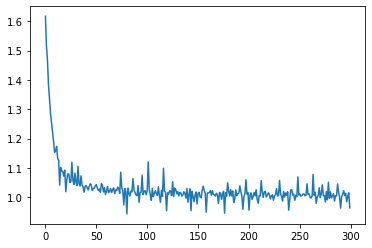

In [6]:
plt.plot([i.cpu().detach().numpy() for i in loss_list])

In [7]:
[i.cpu().detach().numpy() for i in loss_list][:10]

[array(1.6169871, dtype=float32),
 array(1.5155858, dtype=float32),
 array(1.4672112, dtype=float32),
 array(1.384324, dtype=float32),
 array(1.3356369, dtype=float32),
 array(1.2868825, dtype=float32),
 array(1.2556262, dtype=float32),
 array(1.2247393, dtype=float32),
 array(1.1900278, dtype=float32),
 array(1.1531363, dtype=float32)]